### Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import cross_val_score
import pickle

In [2]:
df = pd.read_csv("../data/info_02.csv")

## Análisis Exploratorio

In [3]:
df.describe()

,id,id2,v1,c1,v2
count,17286.000000,17286.000000,17286.000000,17286.000000,17286.000000
mean,4075.651047,4075.651047,119.141542,0.211674,20.617257
std,2347.052912,2347.052912,194.511597,0.408507,1.018207
min,1.000000,1.000000,0.000000,0.000000,19.000000
25%,2042.250000,2042.250000,0.000000,0.000000,19.700000
50%,4086.000000,4086.000000,0.000000,0.000000,20.400000
75%,6102.750000,6102.750000,252.000000,0.000000,21.400000
max,8143.000000,8143.000000,1546.300000,1.000000,23.200000


In [4]:
df.dtypes

id       int64
id2      int64
v1     float64
c1       int64
v2     float64
v3      object
dtype: object

In [5]:
df.head()

,id,id2,v1,c1,v2,v3
0,1,1,426.0,1,23.2,2015-02-04 17:51:00
1,1,1,426.0,1,23.2,2015-02-04 17:51:00
2,2,2,429.5,1,23.1,2015-02-04 17:51:59
3,2,2,429.5,1,23.1,2015-02-04 17:51:59
4,3,3,426.0,1,23.1,2015-02-04 17:53:00


## Buscando y eliminando columnas duplicadas

In [6]:
print(f"Número de registros duplicados entre id y id2: {(df["id"] == df["id2"]).sum()}")
print(f"Número total de registros: {len(df)}")

Número de registros duplicados entre id y id2: 17286
Número total de registros: 17286


In [7]:
df.drop(["id2"], axis=1, inplace=True)

In [8]:
print(f"Registros duplicados: {len(df) - len(df.drop_duplicates())}")

Registros duplicados: 8143


In [9]:
df.drop_duplicates(inplace=True)

In [10]:
print(f"Número de registros sin datos duplicados: {len(df)}")

Número de registros sin datos duplicados: 9143


## Identificación de valores Nulos

<Axes: >

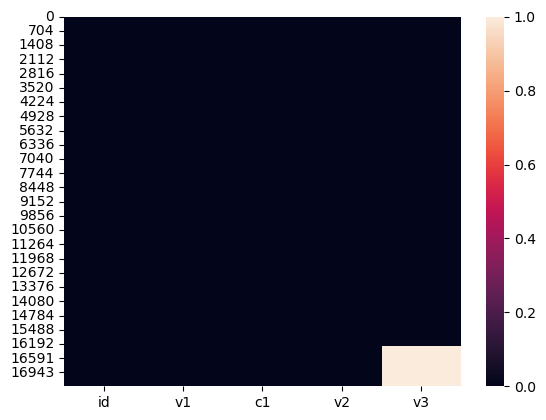

In [11]:
sns.heatmap(df.isnull())

In [12]:
df.isnull().sum()

id       0
v1       0
c1       0
v2       0
v3    1000
dtype: int64

In [13]:
print(f"Número de valores nulos en v3: {df["v3"].isnull().sum()}")

Número de valores nulos en v3: 1000


In [14]:
class0 = df[df['v3'].isnull()].groupby('c1').size()[0]
class1 = df[df['v3'].isnull()].groupby('c1').size()[1]

print(f"Número de valores nulos en la clase '0': {class0}")
print(f"Número de valores nulos en la clase '1': {class1}")

Número de valores nulos en la clase '0': 799
Número de valores nulos en la clase '1': 201


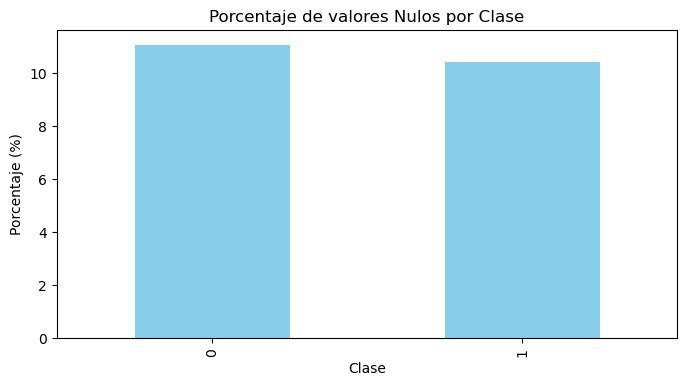

In [15]:
totalClass = df["c1"].value_counts()
nullClass = df[df['v3'].isnull()].groupby('c1').size()
nullsPercent = (nullClass / totalClass)*100

plt.figure(figsize=(8, 4))
nullsPercent.plot(kind='bar', color='skyblue')
plt.title('Porcentaje de valores Nulos por Clase')
plt.xlabel('Clase')
plt.ylabel('Porcentaje (%)')
plt.show()

## Identificación de Outliers

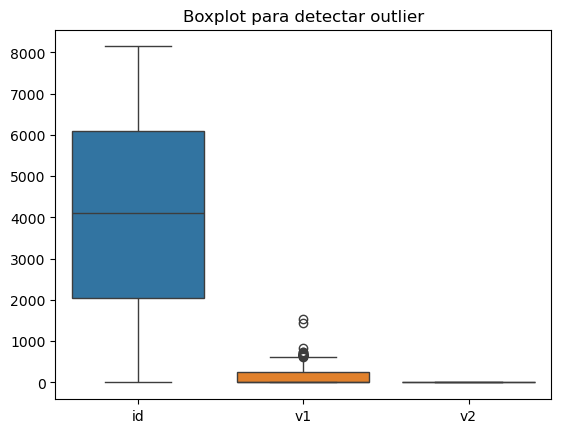

In [16]:
sns.boxplot(df.drop(["c1"], axis=1))
plt.title("Boxplot para detectar outlier")
plt.show()

In [17]:
quantile1 = df["v1"].quantile(0.25)
quantile3 = df["v1"].quantile(0.75)

iqr = quantile3- quantile1
upperFence = quantile3 + 1.5 * iqr
lowerFence = quantile1 - 1.5 * iqr

outliers = df[(df["v1"] < lowerFence) | (df["v1"] > upperFence)]

print(f"Número de outliers detectados: {len(outliers)}")
print(f"Porcentaje de outliers: {round(len(outliers)*100/len(df),2)}")

Número de outliers detectados: 20
Porcentaje de outliers: 0.22


In [18]:
df = df[(df["v1"] <= upperFence) & (df["v1"] >= lowerFence)]

## Detección de correlaciones (Pearson)

In [19]:
df["v3"] = pd.to_datetime(df["v3"])

In [20]:
df["year"] = df["v3"].dt.year
df["month"] = df["v3"].dt.month
df["day"] = df["v3"].dt.day
df["hour"] = df["v3"].dt.hour
df["minute"] = df["v3"].dt.minute

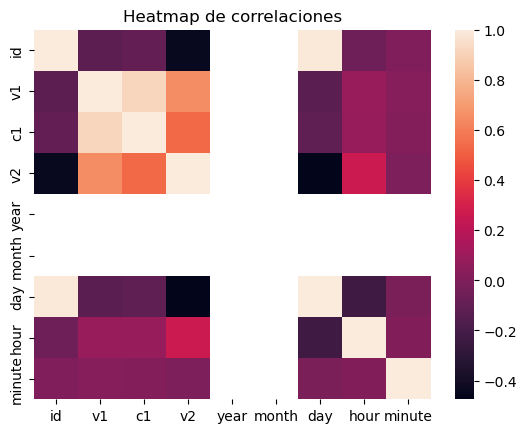

In [21]:
corr = df.drop(["v3"], axis=1).corr()

sns.heatmap(corr)
plt.title("Heatmap de correlaciones")
plt.show()

In [22]:
corr

,id,v1,c1,v2,year,month,day,hour,minute
id,1.000000,-0.119980,-0.098103,-0.440261,NaN,NaN,0.984278,-0.054410,-0.000330
v1,-0.119980,1.000000,0.916015,0.651672,NaN,NaN,-0.128734,0.086029,0.022273
c1,-0.098103,0.916015,1.000000,0.536724,NaN,NaN,-0.106491,0.079571,0.015935
v2,-0.440261,0.651672,0.536724,1.000000,NaN,NaN,-0.474408,0.260482,-0.004273
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,0.984278,-0.128734,-0.106491,-0.474408,NaN,NaN,1.000000,-0.229771,-0.008168
hour,-0.054410,0.086029,0.079571,0.260482,NaN,NaN,-0.229771,1.000000,0.003730
minute,-0.000330,0.022273,0.015935,-0.004273,NaN,NaN,-0.008168,0.003730,1.000000


### Eliminando caracteristicas no relevantes

In [23]:
df.drop(["year", "month", "minute", "hour", "v3"], axis=True, inplace=True)

In [24]:
def impute_mode(series):
    return series.mode()[0]

In [25]:
df['day'] = df.groupby('id')['day'].transform(lambda x: x.fillna(impute_mode(x)))

In [26]:
df.corr()

,id,v1,c1,v2,day
id,1.000000,-0.119980,-0.098103,-0.440261,0.984163
v1,-0.119980,1.000000,0.916015,0.651672,-0.132705
c1,-0.098103,0.916015,1.000000,0.536724,-0.110109
v2,-0.440261,0.651672,0.536724,1.000000,-0.475176
day,0.984163,-0.132705,-0.110109,-0.475176,1.000000


## Comprobando el balance entre clases

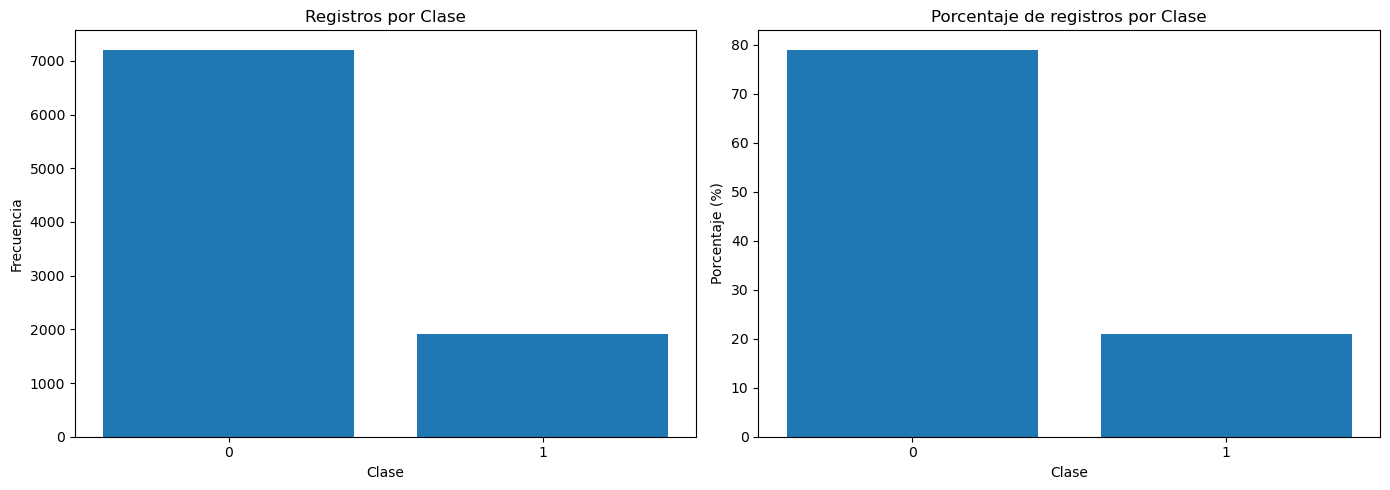

In [27]:
valueCounts = df["c1"].astype(str).value_counts()
labelsName = valueCounts.index
percentages = (valueCounts/valueCounts.sum()) * 100

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].bar(labelsName, valueCounts)
axs[0].set_title('Registros por Clase')
axs[0].set_xlabel('Clase')
axs[0].set_ylabel('Frecuencia')

axs[1].bar(labelsName, percentages)
axs[1].set_title('Porcentaje de registros por Clase')
axs[1].set_xlabel('Clase')
axs[1].set_ylabel('Porcentaje (%)')

plt.tight_layout()
plt.show()

## Entrenamiento del modelo y comparación del rendimiento

In [28]:
X = df.drop(["c1"], axis=1)
y = df["c1"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ])

smote = SMOTE(random_state=42)

classifiers = {
    'XGBoost': xgb.XGBClassifier(eval_metric='mlogloss'),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier()
}

for name, classifier in classifiers.items():
    pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                                  ('smote', smote),
                                  ('classifier', classifier)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    with open("../data/"+name.replace(" ","_")+"_model.pkl", 'wb') as file:
        pickle.dump(pipeline, file)
        
    print(f"{name} Reporte:\n{classification_report(y_test, y_pred)}")


XGBoost Reporte:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1481
           1       0.96      1.00      0.98       344

    accuracy                           0.99      1825
   macro avg       0.98      1.00      0.99      1825
weighted avg       0.99      0.99      0.99      1825

SVM Reporte:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1481
           1       0.93      1.00      0.96       344

    accuracy                           0.99      1825
   macro avg       0.97      0.99      0.98      1825
weighted avg       0.99      0.99      0.99      1825

Random Forest Reporte:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1481
           1       0.98      1.00      0.99       344

    accuracy                           1.00      1825
   macro avg       0.99      1.00      0.99      1825
weighted avg       1.

## Validación cruzada para evaluar Overfitting

In [29]:
for name, classifier in classifiers.items():
    temp_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('classifier', classifier)
    ])

    cv_scores = cross_val_score(temp_pipeline, X, y, cv=5, scoring='accuracy')

    print(f"{name} - CV Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std():.2f})")

XGBoost - CV Accuracy: 0.99 (+/- 0.01)
SVM - CV Accuracy: 0.99 (+/- 0.01)
Random Forest - CV Accuracy: 0.99 (+/- 0.00)
